# 1. **Подключаем библиотеки и скрипты:**

In [428]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv
/kaggle/input/real-estate-price-prediction-moscow/train.csv
/kaggle/input/real-estate-price-prediction-moscow/test.csv


In [429]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from lightgbm import LGBMRegressor

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [430]:
import warnings
warnings.filterwarnings('ignore')

In [431]:
matplotlib.rcParams.update({'font.size': 14})

In [432]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()


Прописываем пути к файлам:

In [433]:
TRAIN_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'

# **2. Загружаем данные**

In [434]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [435]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [436]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [437]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [438]:
train_df.shape[1] - 1 == test_df.shape[1]

True

**Приведение типов данных к необходимым:**

In [439]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [440]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

# **3. Проверяем данные**

**Посмотрим на распределение по целевой переменной (Price)**

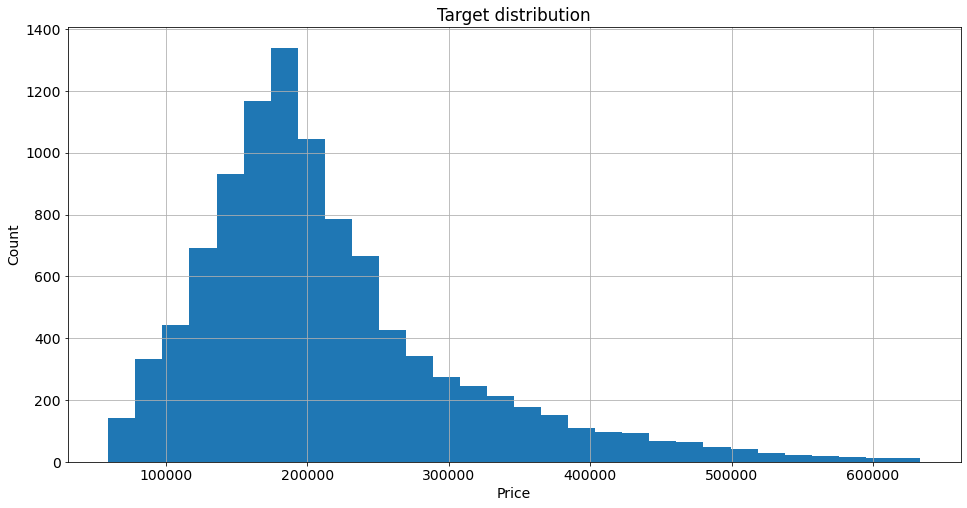

In [441]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

**Рассмотрим количественные переменные на предмет возможных выбросов и NaN**

In [442]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Обращаем внимание на аномальные значения Rooms (min, max), KitchenSquare (min, max), HouseFloor (min, max)**
**Будем относиться к данным значениям как к выбросам; обработаем их в следующем пункте**

**Далее рассмотрим номинативные переменные:**

In [443]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [444]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
196      1
209      1
207      1
174      1
117      1
Name: DistrictId, Length: 205, dtype: int64

In [445]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [446]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [447]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

# **4. Обрабатываем выбросы и пропуски**

**Rooms**

In [448]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

**Значения Rooms в диапазоне [1;6] считаем нормой. Значения 0 и > 6 считаем выбросом. Заменим все выбросы по следующему принципу:**
* **Предположим, что значения 0 на самом деле соответствуют квартирам-студиям; Тогда присвоим этим значениям значение 1 (квартиры-студии будут соответствовать однокомнатным квартирам)**
* **Предположим, что значения > 6 занесены ошибочно; тогда заменим эти значения медианными по трейну**

In [449]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] > 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [450]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] > 6, 'Rooms'] = train_df['Rooms'].median()

In [451]:
train_df['Rooms'].value_counts()

2.0    3883
1.0    3713
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

**Теперь ситуация с комнатами выглядит более реалистичной**

**KitchenSquare**

In [452]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
51.0         2
58.0         2
37.0         2
32.0         2
41.0         2
43.0         2
30.0         2
25.0         2
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
66.0         1
2014.0       1
31.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
62.0         1
75.0         1
Name: KitchenSquare, dtype: int64

In [453]:
train_df['KitchenSquare'].quantile(.99), train_df['KitchenSquare'].quantile(.01)

(16.0, 0.0)

 **Предположим, что нормальным максимальным значением является площадь кухни 16 м^2; также будем считать, что значения менее 5 ошибочны и заменим их на 5**

In [454]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.99))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 5, 'KitchenSquare'] = 5

In [455]:
train_df['KitchenSquare'].value_counts()

5.0     4391
8.0     1306
6.0     1129
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
14.0      51
15.0      31
16.0      16
Name: KitchenSquare, dtype: int64

**Floor, HouseFloor**

In [456]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [457]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [458]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

**В 1825 случаях значение этажа квартиры превышает значение этажности дома. Для таких случаев предположим, что значения были занесены ошибочно и вместо имеющегося значения внесем случайное в пределах этажности дома.**

In [459]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

**Для случаев, где этажность дома нулевая, заменим значения на медианные**

In [460]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [461]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [462]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

**Убедимся, что не осталось случаев, где этаж квартиры превышает этажность дома**

In [463]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

**HouseYear**

In [464]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

**Предположим, что значение 20052011 соответствует году начала (2005) и году конца (2011) строительства. Тогда заменим значение на 2011, так как будем считать, что дом сдан в 2011 году. Данное действие актуально только для текущего трейна**

In [465]:
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = int(2011)

**Прочие значения, превышающие текущий (2021) год, заменим на 2021**

In [466]:
train_df.loc[train_df['HouseYear'] > 2021, 'HouseYear'] = 2021

**Обрабатываем пропуски**

In [467]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

In [468]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,NaN,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,NaN,5.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,6.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,5.0
9,79.867477,75.085125,5.0


**Обработаем пропуски по Lifesquare.**
**Используем следующую предпослылку: Жилая площадь = Общая площадь - Площадь нежилых помещений; Площадь нежилых помещение будем считать Площадью кухни плюс 5 кв.м.**

In [469]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 5

**Обработаем пропуски по Healthcare, исключив признак т.к. у нас отсутствует понимание о смысле признака**

In [470]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

**Объявим класс DataPreprocessing, где отразим все созданные методы предобработки данных:**

In [471]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.99)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (train_df['Rooms'] > 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] > 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 5, 'KitchenSquare'] = 5
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

# **5. Генерация новых признаков**

**Dummies - заменим триггерные признаки А/В на 0/1**

In [472]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

**DistrictSize, IsDistrictLarge**

**Создадим признак по размеру района**

In [473]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [474]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize
0,11809,27,3.0,115.027311,100.027311,10.0,4,10.0,2014,0.075424,...,3097,0,0,0,1,305018.871089,0,0,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,6207,1,1,0,1,177734.553407,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,5261,0,3,1,1,282078.720850,0,0,0,652
3,2352,1,1.0,40.409907,30.409907,5.0,10,22.0,1977,0.007122,...,264,0,0,1,1,168106.007630,0,0,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,8667,2,0,6,1,343995.102962,0,0,0,89


**Подсчитаем, сколько районов состоят из более чем 100 квартир**

In [475]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

**Cоздадим новый признак IsDistrictLarge и для всех районов, состоящих из более чем 100 квартир, проставим значения 1**

In [476]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

**Создадим признак MedPriceByDistrict - медианную цену по району**

In [477]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [478]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,100.027311,10.0,4,10.0,2014,0.075424,...,0,0,1,305018.871089,0,0,1,851,1,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,0,1,177734.553407,0,0,0,78,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,3,1,1,282078.720850,0,0,0,652,1,244005.272380
3,2352,1,1.0,40.409907,30.409907,5.0,10,22.0,1977,0.007122,...,0,1,1,168106.007630,0,0,1,652,1,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,6,1,343995.102962,0,0,0,89,0,201584.441255


 **MedPriceByFloorYear - медианная цена по группам этажности и года постройки**

**Объявим функцию, разделяющую датасет на группы по этажности, возрасту здания**

In [479]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [480]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    3
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [481]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0         (3, 5]
1         (5, 9]
2         (0, 3]
3        (9, 15]
4       (15, 42]
          ...   
9995      (0, 3]
9996     (9, 15]
9997      (0, 3]
9998      (0, 3]
9999      (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [482]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027311,100.027311,10.0,4,10.0,2014,0.075424,...,1,305018.871089,0,0,1,851,1,213530.788443,6,2
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,177734.553407,0,0,0,78,0,146032.829834,3,3
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,282078.720850,0,0,0,652,1,244005.272380,4,1
3,2352,1,1.0,40.409907,30.409907,5.0,10,22.0,1977,0.007122,...,1,168106.007630,0,0,1,652,1,146735.671740,3,4
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,1,343995.102962,0,0,0,89,0,201584.441255,3,5


**Рассчитаем медианную цену для групп**

In [483]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,377548.385806
1,1,2,321497.418777
2,1,3,396262.354728
3,1,4,274992.472366
4,2,1,467230.539057


In [484]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,100.027311,10.0,4,10.0,2014,0.075424,...,305018.871089,0,0,1,851,1,213530.788443,6,2,161974.797753
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,177734.553407,0,0,0,78,0,146032.829834,3,3,191935.165175
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,282078.720850,0,0,0,652,1,244005.272380,4,1,201943.912667
3,2352,1,1.0,40.409907,30.409907,5.0,10,22.0,1977,0.007122,...,168106.007630,0,0,1,652,1,146735.671740,3,4,183718.550817
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,343995.102962,0,0,0,89,0,201584.441255,3,5,173934.865013


**Соберем методы предобработки данных в один класс:**

In [485]:
class FeatureGenetator():
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
            

# **6. Отберем признаки**

**Признаки отберем по принципу участия в модели предсказания**

In [486]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [487]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']

target_name = 'Price'

# **7. Разбиение на Train и Test**

In [488]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [489]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [490]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [491]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 29), (3300, 29), (5000, 29))

In [492]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [493]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

# **8. Построение модели**

**LGBMRegressor**

**Обучение модели**

In [494]:
lgbm_regressor_model = LGBMRegressor()
lgbm_regressor_model.fit(X_train, y_train)

LGBMRegressor()

**Оценка модели**

Train R2:	0.89
Test R2:	0.721


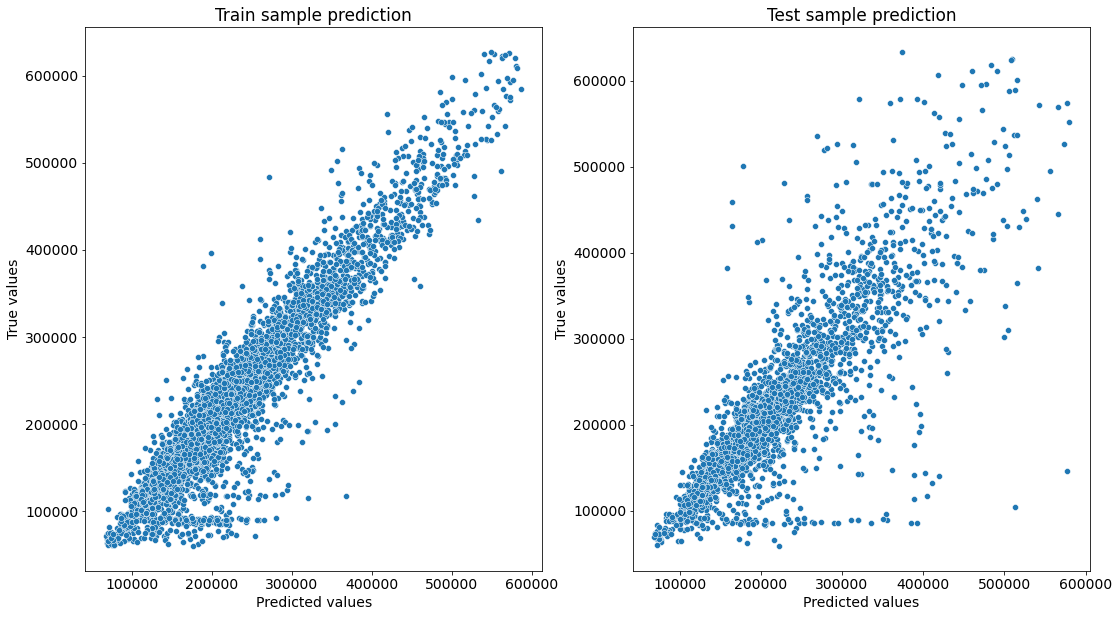

In [495]:
y_train_preds = lgbm_regressor_model.predict(X_train)
y_test_preds = lgbm_regressor_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Кросс-валидация**

In [496]:
cv_score = cross_val_score(lgbm_regressor_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.78068604, 0.74390623, 0.75774979])

In [497]:
cv_score.mean()

0.7607806881090271

**Оценка важности признаков**

In [498]:
feature_importances = pd.DataFrame(zip(X_train.columns, lgbm_regressor_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,434
23,MedPriceByDistrict,361
6,HouseYear,259
20,DistrictSize,237
7,Ecology_1,228
2,LifeSquare,221
5,HouseFloor,206
3,KitchenSquare,149
10,Social_1,145
11,Social_2,141


# **9. Прогнозирование на тестовом датасете**

In [499]:
test_df.shape

(5000, 25)

In [500]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,MedPriceByDistrict,MedPriceByFloorYear
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,1,0,0,0,0,76.0,0,0,171145.169069,188697.720287
1,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,...,0,0,0,0,0,164.0,0,1,131107.271962,180042.914720
2,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,1,1,...,1,0,0,0,1,580.0,0,1,165993.292450,173028.982008
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,1,0,0,0,0,372.0,0,1,172778.615365,179439.005005
4,1.0,53.837056,45.837056,5.0,8,17.0,1977,0.309479,1,1,...,1,0,0,0,1,65.0,0,0,164116.183543,192605.568622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,4,5.0,1962,0.069660,1,1,...,1,0,1,0,0,56.0,0,0,183575.963167,188697.720287
4996,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,1,1,...,1,0,0,0,0,26.0,0,0,425037.641820,199166.198392
4997,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,1,1,...,1,0,0,0,0,54.0,0,0,156266.487610,179439.005005
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,1,...,1,0,0,0,0,40.0,0,0,185704.766694,192605.568622


In [501]:
submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [502]:
predictions = lgbm_regressor_model.predict(test_df)
predictions

array([163997.96658159, 127836.80101513, 141272.95155403, ...,
       145837.00523624, 188690.40801645, 268121.74261062])

In [503]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,163997.966582
1,5925,127836.801015
2,960,141272.951554
3,3848,104665.342407
4,746,184414.895258


In [504]:
submit.to_csv('lgbm_regressor_submit.csv', index=False)